In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Dataset Shape: (1947, 14)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1947 entries, 0 to 1946
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   name                                  1947 non-null   object 
 1   country_of_citizenship                1947 non-null   object 
 2   position                              1947 non-null   object 
 3   foot                                  1947 non-null   object 
 4   height_in_cm                          1947 non-null   float64
 5   current_club_domestic_competition_id  1947 non-null   object 
 6   current_club_name                     1947 non-null   object 
 7   market_value_in_eur                   1947 non-null   float64
 8   yellow_cards                          1947 non-null   int64  
 9   red_cards                             1947 non-null   int64  
 10  goals                                 1947 

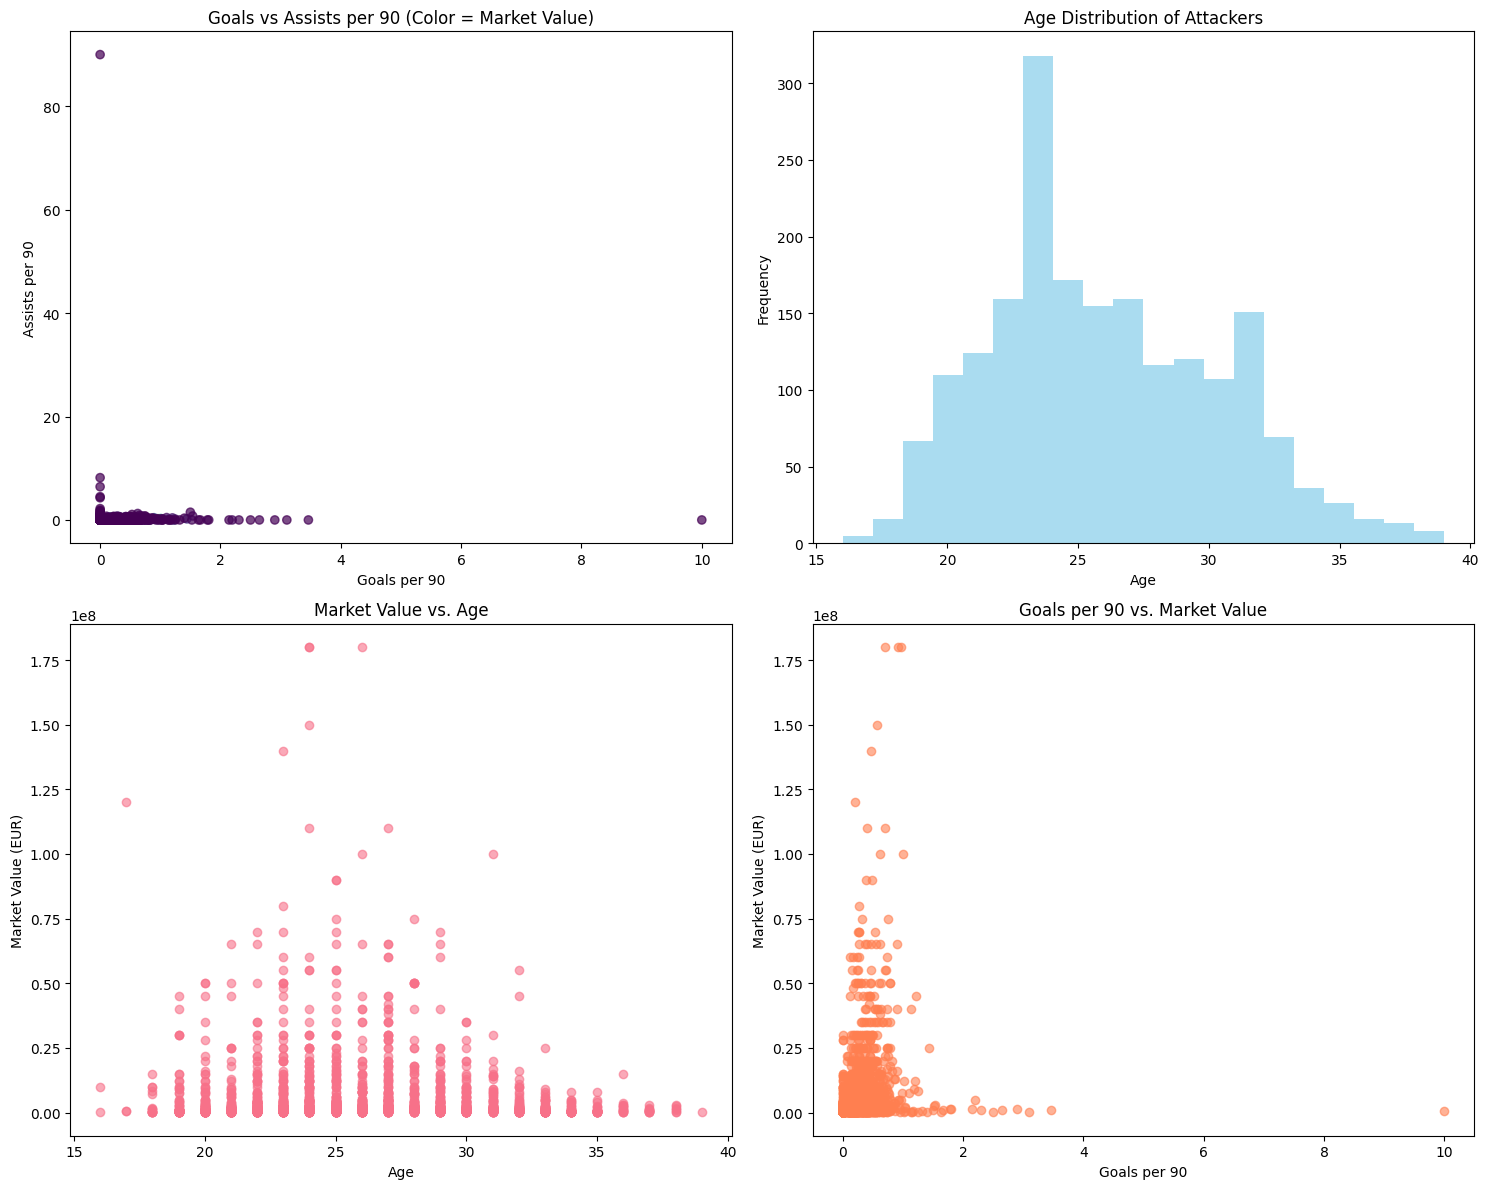

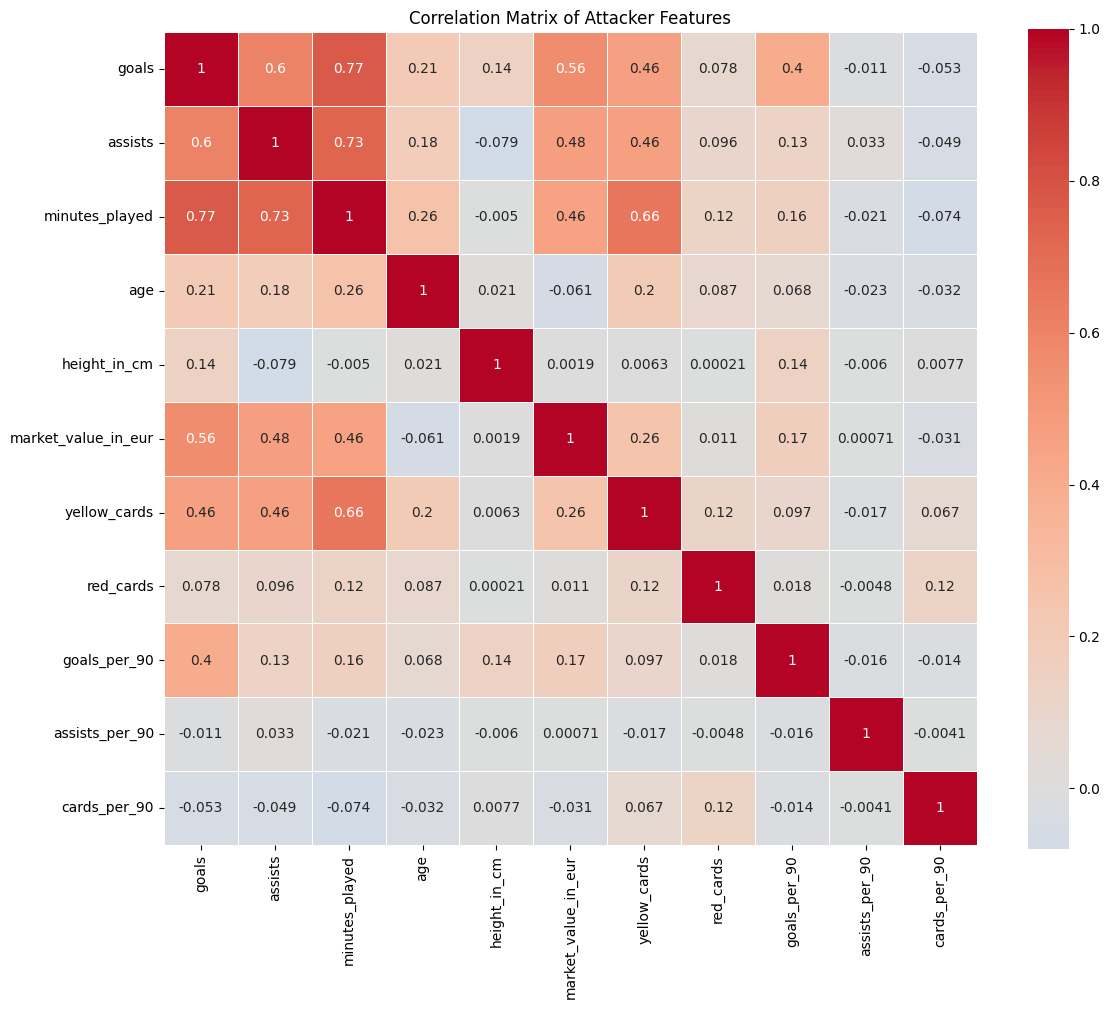


 Attackers Market Value Prediction - Results

--- Training Set Performance ---
Accuracy: -96.68%
R-squared (R²): 0.7408
Mean Absolute Error (MAE): 3,192,218.82 EUR
Root Mean Squared Error (RMSE): 7,904,724.30 EUR

--- Test Set Performance ---
Accuracy: -184.91%
R-squared (R²): 0.3219
Mean Absolute Error (MAE): 4,731,936.24 EUR
Root Mean Squared Error (RMSE): 8,830,306.18 EUR


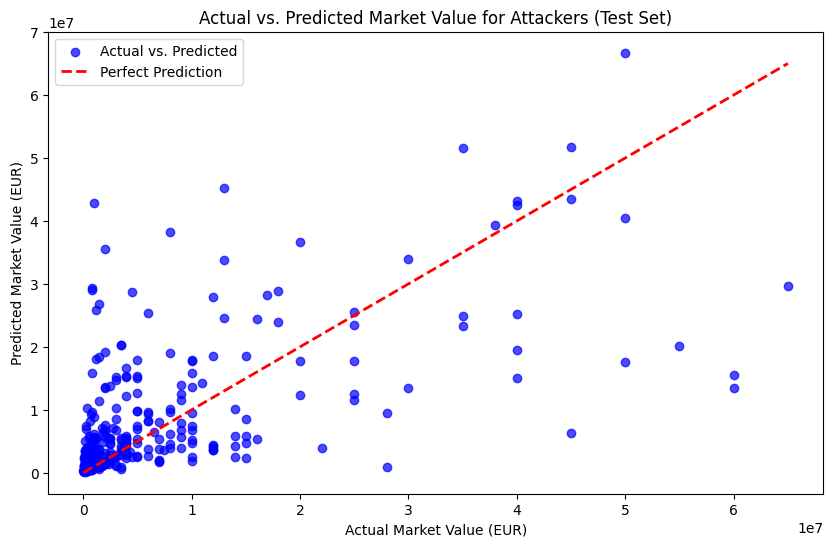


Top 10 Feature Importances:
                                          importance
goals_per_90                                0.259351
assists_per_90                              0.159855
current_club_domestic_competition_id_GB1    0.137628
height_in_cm                                0.093896
age                                         0.091050
cards_per_90                                0.077931
current_club_domestic_competition_id_ES1    0.033614
current_club_domestic_competition_id_IT1    0.031678
country_of_citizenship_Brazil               0.024812
current_club_domestic_competition_id_L1     0.019408


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
import warnings

warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

# 1. DATA LOADING AND INITIAL EXPLORATION
# Use the correct Kaggle file path
file_path = '/kaggle/input/attacker-mktval/attackers_only.csv'
df = pd.read_csv(file_path)

print("Dataset Shape:", df.shape)
print("\nDataset Info:")
df.info()

print("\nFirst 5 rows:")
print(df.head())

print("\nBasic Statistics:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())

# 2. DATA CLEANING AND PREPROCESSING
# Drop rows with missing values, if any
df = df.dropna()

# Feature Engineering: Create performance metrics per 90 minutes
df['goals_per_90'] = (df['goals'] / df['minutes_played']) * 90
df['assists_per_90'] = (df['assists'] / df['minutes_played']) * 90
df['cards_per_90'] = ((df['yellow_cards'] + df['red_cards'] * 2) / df['minutes_played']) * 90

# Replace infinite values that can result from division by zero if 'minutes_played' is 0
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)


# 3. EXPLORATORY DATA ANALYSIS (EDA)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Goals vs Assists, color-coded by market value
axes[0, 0].scatter(df['goals_per_90'], df['assists_per_90'], c=df['market_value_in_eur'], cmap='viridis', alpha=0.7)
axes[0, 0].set_xlabel('Goals per 90')
axes[0, 0].set_ylabel('Assists per 90')
axes[0, 0].set_title('Goals vs Assists per 90 (Color = Market Value)')

# Plot 2: Age Distribution
axes[0, 1].hist(df['age'], bins=20, alpha=0.7, color='skyblue')
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Age Distribution of Attackers')

# Plot 3: Market Value vs. Age
axes[1, 0].scatter(df['age'], df['market_value_in_eur'], alpha=0.6)
axes[1, 0].set_xlabel('Age')
axes[1, 0].set_ylabel('Market Value (EUR)')
axes[1, 0].set_title('Market Value vs. Age')

# Plot 4: Goals per 90 vs. Market Value
axes[1, 1].scatter(df['goals_per_90'], df['market_value_in_eur'], alpha=0.6, color='coral')
axes[1, 1].set_xlabel('Goals per 90')
axes[1, 1].set_ylabel('Market Value (EUR)')
axes[1, 1].set_title('Goals per 90 vs. Market Value')

plt.tight_layout()
plt.show()

# 4. CORRELATION ANALYSIS
numerical_features = ['goals', 'assists', 'minutes_played', 'age', 'height_in_cm',
                      'market_value_in_eur', 'yellow_cards', 'red_cards',
                      'goals_per_90', 'assists_per_90', 'cards_per_90']

correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Correlation Matrix of Attacker Features')
plt.tight_layout()
plt.show()


# 5. MODEL TRAINING AND PREDICTION
# Feature Selection and Encoding
features = ['age', 'height_in_cm', 'goals_per_90', 'assists_per_90', 'cards_per_90',
            'foot', 'country_of_citizenship', 'current_club_domestic_competition_id']
target = 'market_value_in_eur'

# One-Hot Encode categorical features
df_encoded = pd.get_dummies(df, columns=['foot', 'country_of_citizenship', 'current_club_domestic_competition_id'], drop_first=True)

# Update feature list after one-hot encoding
encoded_features = [col for col in df_encoded.columns if col.startswith(tuple(features)) and col != target]


X = df_encoded[encoded_features]
y = df_encoded[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForestRegressor model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42, min_samples_leaf=3)
rf_regressor.fit(X_train, y_train)

# Make predictions on both training and testing data
y_pred_test = rf_regressor.predict(X_test)
y_pred_train = rf_regressor.predict(X_train)


# 6. MODEL EVALUATION
# --- Helper function for MAPE ---
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

# --- Test Set Evaluation ---
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
accuracy_test = 100 - mape_test

# --- Training Set Evaluation ---
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
accuracy_train = 100 - mape_train


print("\n================================================")
print(" Attackers Market Value Prediction - Results")
print("================================================")
print("\n--- Training Set Performance ---")
print(f"Accuracy: {accuracy_train:.2f}%")
print(f"R-squared (R²): {r2_train:.4f}")
print(f"Mean Absolute Error (MAE): {mae_train:,.2f} EUR")
print(f"Root Mean Squared Error (RMSE): {rmse_train:,.2f} EUR")

print("\n--- Test Set Performance ---")
print(f"Accuracy: {accuracy_test:.2f}%")
print(f"R-squared (R²): {r2_test:.4f}")
print(f"Mean Absolute Error (MAE): {mae_test:,.2f} EUR")
print(f"Root Mean Squared Error (RMSE): {rmse_test:,.2f} EUR")


# Plotting actual vs. predicted values for the TEST SET
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.7, color='blue', label='Actual vs. Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel("Actual Market Value (EUR)")
plt.ylabel("Predicted Market Value (EUR)")
plt.title("Actual vs. Predicted Market Value for Attackers (Test Set)")
plt.legend()
plt.show()

# Feature Importance
feature_importances = pd.DataFrame(rf_regressor.feature_importances_,
                                     index = X_train.columns,
                                     columns=['importance']).sort_values('importance', ascending=False)

print("\nTop 10 Feature Importances:")
print(feature_importances.head(10))